Early stopping of model simulations
===================

For certain distance functions and certain models it is possible to calculate the
distance "on the fly" while the model is running.
This is, for instance, possible if the distance is calculated as cumulative sum
and the model is a stochastic process.
For example, Markov Jump Processes belong to this class.
However, we want to keep things simple here and only demonstrate how to use the pyABC
interface in such cases.
So don't expect a sophisticated (or even useful) model implementation here.

In [2]:
from pyabc import (ABCSMC,
                   RV, Distribution,
                   IntegratedModel, ModelResult,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.sampler import SingleCoreSampler
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile
import pandas as pd
import scipy as sp
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

We define here a (very) simple stochastic process, purely for demonstrative reasons.
First, we fix the number of steps *n_steps* to 30.

In [3]:
n_steps = 30

We then define our process as follows:

$$
   x(t+1) = x(t) + s \xi
$$

in which $\xi \sim U(0, 1)$ denotes a uniformly in $[0, 1]$ distributed
random variable and $s$ is the step size, *s = step_size*.

The function *simulate* implements this stochastic process.

In [4]:
def simulate(step_size):
    trajectory = sp.zeros(n_steps)
    for t in range(1, n_steps):
        xi = sp.rand()
        trajectory[t] = trajectory[t-1] + xi * step_size
    return trajectory

We take as distance function between two such generated trajectories
the sum of the absolute values of the pointwise differences.

In [5]:
def distance(trajectory_1, trajectory_2):
    return sp.absolute(trajectory_1 - trajectory_2).sum()

Let's run the simulation and plot the trajectories to get a better
idea of the so generated data.
We set the ground truth step size *gt_step_size* to 

In [6]:
gt_step_size = 5

This will be used to generate the data which will be subject to inference later on.

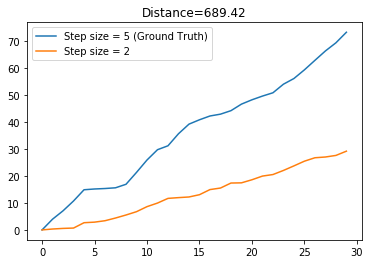

In [7]:
gt_trajectory = simulate(gt_step_size)
trajectoy_2 = simulate(2)

dist_1_2 = distance(gt_trajectory, trajectoy_2)

plt.plot(gt_trajectory,
    label="Step size = {} (Ground Truth)".format(gt_step_size))
plt.plot(trajectoy_2,
    label="Step size = 2")
plt.legend();
plt.title("Distance={:.2f}".format(dist_1_2));

In [8]:
class MyStochasticProcess(IntegratedModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_early_stopped = 0
    
    def integrated_simulate(self, pars, eps):
        cumsum = 0
        trajectory = sp.zeros(n_steps)
        for t in range(1, n_steps):
            xi = sp.rand()
            next_val = trajectory[t-1] + xi * pars["step_size"]
            cumsum += abs(next_val - gt_trajectory[t])
            trajectory[t] = next_val
            if cumsum > eps:
                self.n_early_stopped += 1
                return ModelResult(accepted=False)
            
        return ModelResult(accepted=True,
                           distance=cumsum,
                           sum_stats={"trajectory": trajectory})

In [9]:
prior = Distribution(step_size=RV("uniform", 0 , 10))

In [10]:
model = MyStochasticProcess()

In [11]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=None,
             sampler=SingleCoreSampler(),
             population_size=30,
             transitions=LocalTransition(k_fraction=.2),
             eps=MedianEpsilon(300, median_multiplier=0.7))

In [12]:
abc.new(db_path)

INFO:Epsilon:initial epsilon is 300
INFO:History:Start <ABCSMC(id=16, start_time=2018-04-08 14:18:33.809517, end_time=None)>


16

In [13]:
h = abc.run(minimum_epsilon=40, max_nr_populations=3)

INFO:ABC:t:0 eps:300
INFO:ABC:t:1 eps:118.98353014314029
INFO:ABC:t:2 eps:57.227318576469294
INFO:History:Done <ABCSMC(id=16, start_time=2018-04-08 14:18:33.809517, end_time=2018-04-08 14:18:50.936733)>


In [14]:
model.n_early_stopped

1940

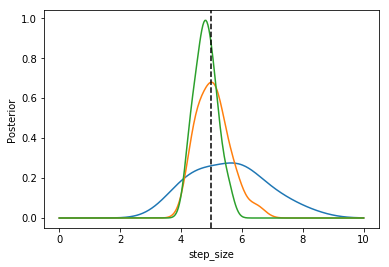

In [15]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(h.max_t+1):
    particles = h.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "step_size",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(gt_step_size, color="k", linestyle="dashed");    